# Training Word Embeddings with gensim Word2Vec

In [1]:
import re, pickle

import gensim, nltk, regenerator
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/idfah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
data_stream = regenerator.Stream.from_txt('wikipedia.txt') #.islice(10_1000)
data_stream = data_stream.map(lambda line: line.strip('\r\n')).filter(lambda item: item)
list(data_stream.islice(3))

['Anarchism',
 "Anarchism is an anti-authoritarian political and social philosophy that rejects hierarchy as unjust and advocates its replacement with self-managed, self-governed societies based on voluntary, cooperative institutions. These institutions are often described as stateless societies, although several authors have defined them more specifically as distinct institutions based on non-hierarchical or free associations. Anarchism's central disagreement with other ideologies is that it holds the state to be undesirable, unnecessary, and harmful.",
 'Anarchism is usually placed on the far-left of the political spectrum, and much of its economics and legal philosophy reflect anti-authoritarian interpretations of communism, collectivism, syndicalism, mutualism, or participatory economics. As anarchism does not offer a fixed body of doctrine from a single particular worldview, many anarchist types and traditions exist and varieties of anarchy diverge widely. Anarchist schools of tho

In [4]:
class Tokenizer:                                                                                    
    def __init__(self, language='english'):
        self.language = language
        
        #self.nltk_word_tokenizer = nltk.tokenize.WordPunctTokenizer()
        self.nltk_word_tokenizer = nltk.tokenize.TreebankWordTokenizer()
        self.nltk_sent_tokenizer = nltk.data.load(
            'tokenizers/punkt/{}.pickle'.format(language))
                                                                                                    
    def __call__(self, text):
        return [self.nltk_word_tokenizer.tokenize(sent)
                for sent in self.nltk_sent_tokenizer.tokenize(text)]

In [5]:
tokenizer = Tokenizer()

In [6]:
token_stream = data_stream.map(tokenizer).unnest()
list(token_stream.islice(3))

[['Anarchism'],
 ['Anarchism',
  'is',
  'an',
  'anti-authoritarian',
  'political',
  'and',
  'social',
  'philosophy',
  'that',
  'rejects',
  'hierarchy',
  'as',
  'unjust',
  'and',
  'advocates',
  'its',
  'replacement',
  'with',
  'self-managed',
  ',',
  'self-governed',
  'societies',
  'based',
  'on',
  'voluntary',
  ',',
  'cooperative',
  'institutions',
  '.'],
 ['These',
  'institutions',
  'are',
  'often',
  'described',
  'as',
  'stateless',
  'societies',
  ',',
  'although',
  'several',
  'authors',
  'have',
  'defined',
  'them',
  'more',
  'specifically',
  'as',
  'distinct',
  'institutions',
  'based',
  'on',
  'non-hierarchical',
  'or',
  'free',
  'associations',
  '.']]

In [7]:
lower_token_stream = token_stream.map(lambda line: list(map(str.lower, line)))
list(lower_token_stream.islice(3))

[['anarchism'],
 ['anarchism',
  'is',
  'an',
  'anti-authoritarian',
  'political',
  'and',
  'social',
  'philosophy',
  'that',
  'rejects',
  'hierarchy',
  'as',
  'unjust',
  'and',
  'advocates',
  'its',
  'replacement',
  'with',
  'self-managed',
  ',',
  'self-governed',
  'societies',
  'based',
  'on',
  'voluntary',
  ',',
  'cooperative',
  'institutions',
  '.'],
 ['these',
  'institutions',
  'are',
  'often',
  'described',
  'as',
  'stateless',
  'societies',
  ',',
  'although',
  'several',
  'authors',
  'have',
  'defined',
  'them',
  'more',
  'specifically',
  'as',
  'distinct',
  'institutions',
  'based',
  'on',
  'non-hierarchical',
  'or',
  'free',
  'associations',
  '.']]

In [8]:
vocab_size = 150_000
embed_dim = 128

In [9]:
counts = collections.Counter(lower_token_stream.unnest())
len(counts)

10373727

In [10]:
most_common_words = counts.most_common(vocab_size)
most_common_words[:10]

[('the', 158744676),
 (',', 127369086),
 ('.', 101325279),
 ('of', 74563192),
 ('in', 64654731),
 ('and', 64030532),
 ('a', 46463660),
 ('to', 45261934),
 ('was', 27922337),
 ("''", 25539396)]

In [11]:
del counts

In [12]:
min_count = most_common_words[-1][1]
min_count

235

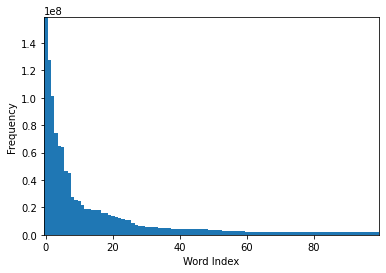

In [13]:
words, counts = zip(*most_common_words[:100])

plt.bar(range(len(counts)), counts, width=1.0);
plt.autoscale(tight=True);
plt.xlabel('Word Index');
plt.ylabel('Frequency');

In [14]:
vocab = set(word for word, count in most_common_words)
list(vocab)[:10]

['sela',
 'burnt',
 'clepsis',
 'petersham',
 'daioh',
 'zsasz',
 'schoeman',
 'african-caribbean',
 'constructing',
 'one-volume']

In [15]:
def replace_word(word):
    if word.isdigit():
        return '<num>'
    
    if not word in vocab:
        return '<unk>'
    
    return word

sub_lower_token_stream = lower_token_stream.map(lambda sent: list(map(replace_word, sent)))

In [16]:
list(sub_lower_token_stream.islice(1, 3))

[['anarchism',
  'is',
  'an',
  'anti-authoritarian',
  'political',
  'and',
  'social',
  'philosophy',
  'that',
  'rejects',
  'hierarchy',
  'as',
  'unjust',
  'and',
  'advocates',
  'its',
  'replacement',
  'with',
  'self-managed',
  ',',
  'self-governed',
  'societies',
  'based',
  'on',
  'voluntary',
  ',',
  'cooperative',
  'institutions',
  '.'],
 ['these',
  'institutions',
  'are',
  'often',
  'described',
  'as',
  'stateless',
  'societies',
  ',',
  'although',
  'several',
  'authors',
  'have',
  'defined',
  'them',
  'more',
  'specifically',
  'as',
  'distinct',
  'institutions',
  'based',
  'on',
  'non-hierarchical',
  'or',
  'free',
  'associations',
  '.']]

In [17]:
with open('tokenized.txt', mode='w', encoding='utf8') as fh:
    for i, sent in enumerate(sub_lower_token_stream):
        fh.write(' '.join(sent) + '\n')

In [18]:
sent_stream = regenerator.Stream.from_txt('tokenized.txt').map(str.split)
list(sent_stream.islice(3))

[['anarchism'],
 ['anarchism',
  'is',
  'an',
  'anti-authoritarian',
  'political',
  'and',
  'social',
  'philosophy',
  'that',
  'rejects',
  'hierarchy',
  'as',
  'unjust',
  'and',
  'advocates',
  'its',
  'replacement',
  'with',
  'self-managed',
  ',',
  'self-governed',
  'societies',
  'based',
  'on',
  'voluntary',
  ',',
  'cooperative',
  'institutions',
  '.'],
 ['these',
  'institutions',
  'are',
  'often',
  'described',
  'as',
  'stateless',
  'societies',
  ',',
  'although',
  'several',
  'authors',
  'have',
  'defined',
  'them',
  'more',
  'specifically',
  'as',
  'distinct',
  'institutions',
  'based',
  'on',
  'non-hierarchical',
  'or',
  'free',
  'associations',
  '.']]

In [19]:
model = gensim.models.Word2Vec(                                                                 
    sent_stream,
    size=embed_dim,
    window=5,
    min_count=min_count,
    workers=20,
    iter=20)

In [20]:
model.wv.most_similar('luke')

[('matthew', 0.8386996388435364),
 ('dominic', 0.8025237321853638),
 ('aidan', 0.788169801235199),
 ('damian', 0.7745775580406189),
 ('patrick', 0.7572060823440552),
 ('brendan', 0.7453355193138123),
 ('michael', 0.7450605630874634),
 ('caleb', 0.7383602857589722),
 ('peter', 0.7357949018478394),
 ('anthony', 0.7302602529525757)]

In [27]:
test_words = ['space', 'trump', 'obama', 'apollo', 'mars', 'the', 'is', 'and', 'cat', 'dog', 'elliott', ',',   
              'maggie', '.', '99', 'bksdhjfbhyjk', 'america', 'canada', 'colorado', 'omega', 'pytorch',
              'ubiquitous', 'deleterious', 'isomorphism', 'aberrant', 'awesomesauce', 'lol', 'yeah', 'nah']

for word in test_words:
    word = replace_word(word)
        
    similar, _scores = zip(*model.wv.most_similar(word))
    print(word, end=': ')
    print(similar)
    print()

space: ('spaces', 'module', 'workspace', 'projection', 'iss', 'microgravity', 'shuttle', 'torus', '3-dimensional', 'sphere')

trump: ('obama', 'reagan', 'nixon', 'putin', 'clinton', 'biden', 'ahmadinejad', 'duterte', 'rumsfeld', 'gingrich')

obama: ('trump', 'reagan', 'clinton', 'nixon', 'barack', 'bush', 'ahmadinejad', 'eisenhower', 'mccain', 'duterte')

apollo: ('gemini', 'orion', 'artemis', 'neptune', 'helios', 'athena', 'jupiter', 'astronauts', 'hermes', 'skylab')

mars: ('martian', 'venus', 'phobos', 'pluto', 'jupiter', 'earth', 'moon', 'uranus', 'lander', 'lunar')

the: ('its', 'this', "'s", 'their', 'a', 'another', 'an', '.the', '—the', 'whose')

is: ('was', 'exists', 'are', 'becomes', 'remains', 'represents', 'occurs', 'became', 'stands', 'contains')

and: ('while', 'which', 'who', '.', 'whilst', 'whose', 'where', 'but', 'and/or', 'whereas')

cat: ('dog', 'rabbit', 'monkey', 'rat', 'pig', 'kitten', 'mouse', 'duck', 'pug', 'puppy')

dog: ('cat', 'rabbit', 'puppy', 'dogs', 'pig',

In [22]:
model.wv.index2word[:10], len(model.wv.index2word)

(['the', ',', '.', 'of', '<unk>', 'in', 'and', '<num>', 'a', 'to'], 147821)

In [23]:
model.wv.vectors, model.wv.vectors.shape

(array([[ 3.7691, -1.2606,  0.2578, -3.4726, ...,  1.1887,  0.8546,
         -7.4062, -0.9216],
        [-0.1039,  0.5348, -1.3165,  1.1579, ..., -1.4058, -1.4554,
          1.1903, -0.0297],
        [-1.1261,  0.7308, -2.7491, -3.3077, ..., -2.9297,  1.4925,
          0.9309, -4.2944],
        [ 4.1354,  1.0388,  0.7864, -2.6224, ..., -0.4612,  4.3914,
         -3.9995, -0.4554],
        ...,
        [-1.5174,  1.1534,  0.6267, -0.6739, ...,  0.9571,  0.6228,
         -0.6503, -0.6041],
        [-1.0901, -3.2518, -1.6252,  1.748 , ..., -1.4135, -0.9131,
         -0.0974,  1.1923],
        [ 0.3889,  0.3065,  1.1851, -0.3175, ...,  0.2799, -1.533 ,
         -1.6776, -0.1554],
        [ 4.1167,  0.4389,  2.8358,  0.8375, ..., -0.645 , -0.8893,
          0.0748, -3.0171]], dtype=float32), (147821, 128))

In [24]:
filename = f'wikipedia-cbow-{embed_dim}d-{vocab_size // 1000}k.txt'

with open(filename, mode='w', encoding='utf8') as fh:
    for word, vector in zip(model.wv.index2word, model.wv.vectors):
        str_vector = ' '.join(str(round(val, 12)) for val in vector)
        fh.write(f'{word} {str_vector}\n')

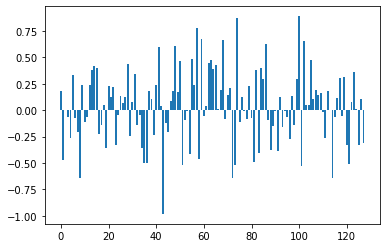

In [25]:
plt.bar(range(embed_dim), model.wv.vectors.mean(axis=0));

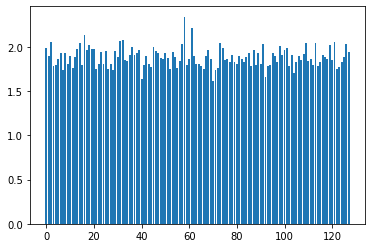

In [26]:
plt.bar(range(embed_dim), model.wv.vectors.std(axis=0));